In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
conf = SparkConf()
#set config
conf = conf.setAppName("ml_sparkSession") \
           .setMaster('local') \
           .set("spark.executor.memory", "2g") \
           .set("spark.executor.cores", "2") \
           .set("spark.sql.shuffle.partitions", "4") \
           .set("spark.executor.instances", "2") \
           .set("spark.jars.packages", "net.snowflake:spark-snowflake_2.12:2.12.0-spark_3.4")

#create Spark Session
spark = SparkSession.builder.config(conf = conf).getOrCreate()

:: loading settings :: url = jar:file:/opt/conda/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
net.snowflake#spark-snowflake_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-51251baf-326d-439b-b4b0-8ec7a073b9e9;1.0
	confs: [default]
	found net.snowflake#spark-snowflake_2.12;2.12.0-spark_3.4 in central
	found net.snowflake#snowflake-ingest-sdk;0.10.8 in central
	found net.snowflake#snowflake-jdbc;3.13.30 in central
downloading https://repo1.maven.org/maven2/net/snowflake/spark-snowflake_2.12/2.12.0-spark_3.4/spark-snowflake_2.12-2.12.0-spark_3.4.jar ...
	[SUCCESSFUL ] net.snowflake#spark-snowflake_2.12;2.12.0-spark_3.4!spark-snowflake_2.12.jar (1496ms)
downloading https://repo1.maven.org/maven2/net/snowflake/snowflake-ingest-sdk/0.10.8/snowflake-ingest-sdk-0.10.8.jar ...
	[SUCCESSFUL ] net.snowflake#snowflake-ingest-sdk;0.10.8!snowflake-ingest-sdk.jar (1540ms)
downloading https://repo1.maven.org/maven2/net/snowflake/snowflake-

In [2]:
#read data
silver_artist = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_artist")
silver_album = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_album")
silver_track = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track")
silver_track_feature = spark.read.parquet("hdfs://namenode:9000/datalake/silver_data/silver_track_feature")
#rename columns
silver_artist = silver_artist.withColumnRenamed('id', 'artist_id') \
                            .withColumnRenamed('name', 'artist_name')
#drop unnecessary columns and rename columns 
silver_album = silver_album.drop('artist', 'label', 'popularity', 'copyrights', 'url', 'link_image') \
                        .withColumnRenamed('id', 'album_id') \
                        .withColumnRenamed('name', 'album_name') \
                        .withColumnRenamed('type', 'album_type')  \
                        .withColumnRenamed('popularity', 'album_popularity')
#joining table and creating summary album table
summary_album_table = silver_artist.join(silver_album, on = 'artist_id', how = 'inner')
summary_album_table = summary_album_table.select('artist_id','artist_name','album_id','album_name',
                        'genres','followers','popularity','link_image','url','album_type',
                        'total_tracks','release_date','release_date_precision')

#joining table and creating summary track feature table
silver_track = silver_track.select('album_id', 'id', 'name', 'preview')
summary_feature_table = silver_track.join(silver_track_feature, on = 'id', how = 'left')
summary_feature_table = summary_feature_table.withColumnRenamed('id', 'track_id')

summary_table = summary_album_table.join(summary_feature_table, on = 'album_id', how = 'inner')
summary_table.cache()

24/12/07 17:31:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, total_tracks: int, release_date: date, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, mode: int, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int]

In [8]:
# summary_album_table.show()
# summary_feature_table.show()
summary_table.show(truncate= False)

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+------------+------------+----------------------+----------------------+--------------------------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link_image                                                      |url                                                   |album_type|total_tracks|release_date|release_date_precision|track_id              |name                                  |preview    

In [3]:
print(summary_table.columns)

['album_id', 'artist_id', 'artist_name', 'album_name', 'genres', 'followers', 'popularity', 'link_image', 'url', 'album_type', 'total_tracks', 'release_date', 'release_date_precision', 'track_id', 'album_name', 'name', 'preview', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


We initially drop the unwanted columns from dataFrame

In [4]:
summary_table = summary_table.drop('album_name', 'album_type', 'release_date_precision', 'time_signature')

2.303.371 size of summary table

### Exploratory Data Analysis (EDA)

- Check artist having most followers on the world

In [5]:
from pyspark.sql.functions import max

# Find the artist having most followers 
max_fl = summary_table.agg(max("followers").alias("max_fl")).collect()[0]["max_fl"]

print(max_fl)

123616624


In [6]:
from pyspark.sql.functions import col
best_playlist = summary_table.filter(col("followers") == max_fl).select("artist_name").distinct()

best_playlist.show(truncate= False)

best_playlist_list = best_playlist.rdd.flatMap(lambda x: x).collect()
print("Best Playlist:\n", best_playlist_list)

+------------+
|artist_name |
+------------+
|Arijit Singh|
+------------+



Best Playlist:
 ['Arijit Singh']


- Check which artists are featured most across all playlist for top 10 artists

/tmp/ipykernel_184/2540731308.py:18: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y = names, x = values, palette= 'pastel')


Text(0.5, 0, 'Total songs across playlists')

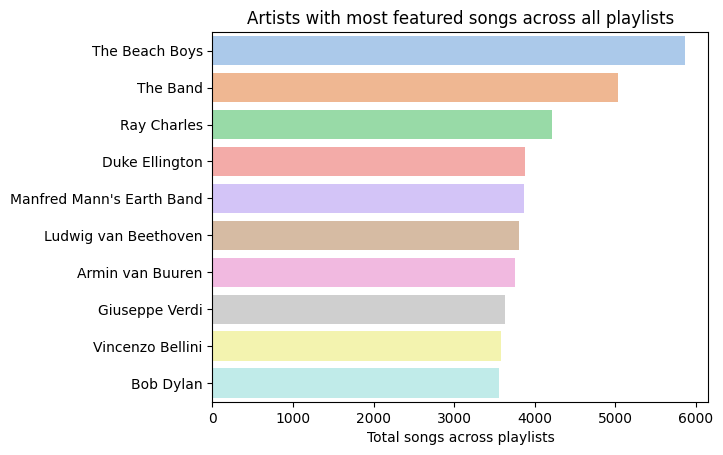

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 

# Step 1: Group by artist_name and count the apparence
artist_counts = summary_table.groupBy("artist_name").count()

# Step 2: Sort descending by the apparence
sorted_artist_counts = artist_counts.orderBy("count", ascending = False)

# Step 3: Convert to pandas to plot data
artist_counts_pd = sorted_artist_counts.limit(10).toPandas()

# Step 4: Take the values and name of artists
values = artist_counts_pd['count'].tolist()
names = artist_counts_pd['artist_name'].tolist()

# Step 5: Plot data with seaborn
ax = sns.barplot(y = names, x = values, palette= 'pastel')
ax.set_title('Artists with most featured songs across all playlists')
ax.set_xlabel('Total songs across playlists')

- Top 10 artists and music genres are most popular in the world

In [8]:
from pyspark.sql import functions as F

# Group by artist_name and calculate mean of followers 
artist_fl = summary_table.groupBy('artist_name').agg(F.mean('followers').alias('followers'))

# Sort by followers in descending order
sorted_artist_fl = artist_fl.orderBy('followers', ascending = False).limit(10)

sorted_artist_fl.show(truncate = False)

+-------------+------------+
|artist_name  |followers   |
+-------------+------------+
|Arijit Singh |1.23616624E8|
|Taylor Swift |1.22781005E8|
|Ed Sheeran   |1.16283003E8|
|Billie Eilish|1.00208733E8|
|Ariana Grande|1.00144929E8|
|Drake        |9.2294533E7 |
|The Weeknd   |9.2004576E7 |
|Eminem       |9.0916937E7 |
|Bad Bunny    |8.600057E7  |
|Justin Bieber|7.7680104E7 |
+-------------+------------+



In [9]:
# Group by genres and calculate mean of popularity
popular_genres = summary_table.groupBy('genres').agg(F.mean('popularity').alias('avg_popularity'))

# Sort by popularity in descending order
sorted_popular_genres = popular_genres.orderBy('avg_popularity', ascending = False).limit(10)

sorted_popular_genres.show(truncate = False)

+----------------------+-----------------+
|genres                |avg_popularity   |
+----------------------+-----------------+
|el paso indie         |85.0             |
|ambient pop           |85.0             |
|big room              |83.73907766990291|
|r&drill               |83.0             |
|south carolina hip hop|83.0             |
|musica tocantinense   |82.83552631578948|
|pittsburgh rap        |82.502722323049  |
|dutch edm             |82.25934579439253|
|nashville hip hop     |82.0             |
|barbadian pop         |81.34782608695652|
+----------------------+-----------------+



### Data Preprocessing

1. Check null values in each columns

In [11]:
from pyspark.sql import functions as F
# Function to check null values in each columns

def count_nulls(df):
    # Calculate null values in each columns
    null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
    
    # Show results
    null_counts.show()

In [13]:
print(count_nulls(summary_table))

24/12/07 16:25:26 INFO CodeGenerator: Code generated in 76.368119 ms
24/12/07 16:25:26 INFO DAGScheduler: Registering RDD 110 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 8
24/12/07 16:25:26 INFO DAGScheduler: Got map stage job 18 (showString at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 16:25:26 INFO DAGScheduler: Final stage: ShuffleMapStage 38 (showString at NativeMethodAccessorImpl.java:0)
24/12/07 16:25:26 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 37, ShuffleMapStage 36)
24/12/07 16:25:26 INFO DAGScheduler: Missing parents: List()
24/12/07 16:25:26 INFO DAGScheduler: Submitting ShuffleMapStage 38 (MapPartitionsRDD[110] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 16:25:26 INFO MemoryStore: Block broadcast_36 stored as values in memory (estimated size 119.3 KiB, free 247.5 MiB)
24/12/07 16:25:26 INFO MemoryStore: Block broadcast_36_piece0 stored as bytes in memory (estim

+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+------------+------------+----------------------+--------+----+-------+------------+------+------+--------+------+-----------+------------+----------------+--------+-------+------+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|total_tracks|release_date|release_date_precision|track_id|name|preview|danceability|energy|   key|loudness|  mode|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+------------+------------+----------------------+--------+----+-------+------------+------+------+--------+------+-----------+------------+----------------+--------+-------+------+--------------+
|       0|        0|          0|         0| 87156|        0|         0|         0|  0|         0|           0|      58737

24/12/07 16:26:18 INFO CodeGenerator: Code generated in 712.651985 ms
24/12/07 16:26:18 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
24/12/07 16:26:18 INFO DAGScheduler: Got job 19 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
24/12/07 16:26:18 INFO DAGScheduler: Final stage: ResultStage 44 (showString at NativeMethodAccessorImpl.java:0)
24/12/07 16:26:18 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 43)
24/12/07 16:26:18 INFO DAGScheduler: Missing parents: List()
24/12/07 16:26:18 INFO DAGScheduler: Submitting ResultStage 44 (MapPartitionsRDD[113] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 16:26:18 INFO MemoryStore: Block broadcast_37 stored as values in memory (estimated size 65.4 KiB, free 124.0 MiB)
24/12/07 16:26:18 INFO MemoryStore: Block broadcast_37_piece0 stored as bytes in memory (estimated size 17.5 KiB, free 123.9 MiB)
24/12/07 16:26:18 INFO BlockMana

2. Drop those columns not affect to build the model

In [9]:
tracks = summary_table.drop('release_date', 'total_tracks', 'mode')

In [12]:
print(count_nulls(tracks))

24/12/07 17:40:09 WARN MemoryStore: Not enough space to cache rdd_38_3 in memory! (computed 62.3 MiB so far)
24/12/07 17:40:09 WARN BlockManager: Persisting block rdd_38_3 to disk instead.


+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|release_date_precision|track_id|name|preview|danceability|energy|   key|loudness|speechiness|acousticness|instrumentalness|liveness|valence| tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+------+--------+-----------+------------+----------------+--------+-------+------+--------------+
|       0|        0|          0|         0| 87156|        0|         0|         0|  0|         0|                     0|       0|  52| 992106|      534770|534770|534770|  534770|     534770|      534770|          534770|

In [13]:
# Function to return shape of table
def shape(df):
    num_rows = df.count()
    nums_cols = len(df.columns)
    
    return (num_rows, nums_cols)

In [11]:
print(shape(tracks))

(2390438, 21)


Vì những cột name là tên bài hát không có nên ta sẽ bỏ những hàng không có tên bài hát đó đi vì nếu không có tên bài hát thì không thể nào recommend cho user

In [14]:
tracks = tracks.dropna(subset = ['name'])
print(shape(tracks))

(2850436, 25)


Vì những cột features như là danceability, energy, acousticness, valence, tempo là những features quan trọng cho việc phân loại theo cảm xúc nên nếu là null values ta sẽ loại bỏ hết những hàng đó

In [15]:
# List of columns need to be dropped
cols_to_drop = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Drop those columns above
tracks = tracks.dropna(subset = cols_to_drop)
print(shape(tracks))

(2315666, 25)


In [13]:
print(count_nulls(tracks))

24/12/07 16:36:22 INFO BlockManagerInfo: Removed broadcast_25_piece0 on c110709c2f0f:46049 in memory (size: 5.8 KiB, free: 214.7 MiB)
24/12/07 16:36:22 INFO BlockManagerInfo: Removed broadcast_24_piece0 on c110709c2f0f:46049 in memory (size: 32.2 KiB, free: 214.7 MiB)
24/12/07 16:36:23 INFO CodeGenerator: Code generated in 74.414682 ms
24/12/07 16:36:23 INFO DAGScheduler: Registering RDD 85 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 7
24/12/07 16:36:23 INFO DAGScheduler: Got map stage job 17 (showString at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 16:36:23 INFO DAGScheduler: Final stage: ShuffleMapStage 56 (showString at NativeMethodAccessorImpl.java:0)
24/12/07 16:36:23 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 54, ShuffleMapStage 55)
24/12/07 16:36:23 INFO DAGScheduler: Missing parents: List()
24/12/07 16:36:23 INFO DAGScheduler: Submitting ShuffleMapStage 56 (MapPartitionsRDD[85] at showString at NativeMethodAcc

+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|release_date_precision|track_id|name|preview|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0|         0| 81748|        0|         0|         0|  0|         0|                     0|       0|   0| 525853|           0|     0|  0|       0|          0|           0|               0|       0|      

24/12/07 16:36:27 INFO Executor: Finished task 3.0 in stage 56.0 (TID 37). 11297 bytes result sent to driver
24/12/07 16:36:27 INFO TaskSetManager: Finished task 3.0 in stage 56.0 (TID 37) in 1000 ms on c110709c2f0f (executor driver) (4/4)
24/12/07 16:36:27 INFO TaskSchedulerImpl: Removed TaskSet 56.0, whose tasks have all completed, from pool 
24/12/07 16:36:27 INFO DAGScheduler: ShuffleMapStage 56 (showString at NativeMethodAccessorImpl.java:0) finished in 4.689 s
24/12/07 16:36:27 INFO DAGScheduler: looking for newly runnable stages
24/12/07 16:36:27 INFO DAGScheduler: running: Set()
24/12/07 16:36:27 INFO DAGScheduler: waiting: Set()
24/12/07 16:36:27 INFO DAGScheduler: failed: Set()
24/12/07 16:36:27 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
24/12/07 16:36:27 INFO DAGScheduler: Got job 18 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
24/12/07 16:36:27 INFO DAGScheduler: Final stage: ResultStage 62 (showString at Nativ

In [16]:
print(tracks.select('track_id').distinct().count())

903635


### Build Recommendation System

##### 1/ Recommend songs by name of song using Content-based Filtering 

In [17]:
summary_table.unpersist()
tracks.cache()

DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int]

In [18]:
tracks_for_cbf = tracks
print(f"Number of unique genres: {tracks_for_cbf.select('genres').distinct().count()}")

Number of unique genres: 2889


1. Find the similarities between input song with each song in dataset

Content-based filtering cung cấp các đề xuất được thiết kế riêng bằng cách tập trung vào sở thích cá nhân, sắp xếp hiệu quả các tùy chọn với sở thích và mối quan tâm riêng của từng người dùng. Điều này thường đạt được thông qua các kỹ thuật như cosin similarities, đo lường độ tương đồng giữa vectơ người dùng (đại diện cho sở thích của người dùng) và hồ sơ mục. Mô hình không cần bất kỳ dữ liệu nào về người dùng khác vì các đề xuất dành riêng cho người dùng này. Điều này giúp dễ dàng mở rộng quy mô cho nhiều người dùng hơn. Mô hình có thể nắm bắt được sở thích cụ thể của người dùng và có thể đề xuất các mặt hàng ngách mà rất ít người dùng khác quan tâm.

Content-based filtering delivers tailored recommendations by focusing on individual preferences, effectively aligning options with each user's unique tastes and interests. This is often achieved through techniques like cosine similarity, which measures the similarity between the user vector (representing the user's preferences) and the item profile. The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users. The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.

- Filtering null values in genres column to empty space ""

In [16]:
from pyspark.sql.functions import col, when

tracks_for_cbf = tracks_for_cbf.withColumn(
    "genres", when(col("genres").isNotNull(), col("genres")).otherwise("")
)

In [17]:
tracks_for_cbf = tracks_for_cbf.withColumn(
    "preview", when(col("preview").isNotNull(), col("preview")).otherwise("")
)

In [18]:
print(count_nulls(tracks_for_cbf))

24/12/07 16:37:43 INFO BlockManagerInfo: Removed broadcast_40_piece0 on c110709c2f0f:46049 in memory (size: 5.8 KiB, free: 194.1 MiB)
24/12/07 16:37:43 INFO BlockManagerInfo: Removed broadcast_39_piece0 on c110709c2f0f:46049 in memory (size: 35.7 KiB, free: 194.1 MiB)
24/12/07 16:37:43 INFO CodeGenerator: Code generated in 56.615341 ms
24/12/07 16:37:43 INFO DAGScheduler: Registering RDD 135 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 14
24/12/07 16:37:43 INFO DAGScheduler: Got map stage job 23 (showString at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 16:37:43 INFO DAGScheduler: Final stage: ShuffleMapStage 86 (showString at NativeMethodAccessorImpl.java:0)
24/12/07 16:37:43 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 84, ShuffleMapStage 85)
24/12/07 16:37:43 INFO DAGScheduler: Missing parents: List()
24/12/07 16:37:43 INFO DAGScheduler: Submitting ShuffleMapStage 86 (MapPartitionsRDD[135] at showString at NativeMethod

+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|album_id|artist_id|artist_name|album_name|genres|followers|popularity|link_image|url|album_type|release_date_precision|track_id|name|preview|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|tempo|time_signature|
+--------+---------+-----------+----------+------+---------+----------+----------+---+----------+----------------------+--------+----+-------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-----+--------------+
|       0|        0|          0|         0|     0|        0|         0|         0|  0|         0|                     0|       0|   0|      0|           0|     0|  0|       0|          0|           0|               0|       0|      

- Tokenizing the genres column and Applying CountVectorizer to count the appearance of each word in genres

In [19]:
from pyspark.ml.feature import Tokenizer, CountVectorizer

# Tokennize the word in genres column
tokenizer = Tokenizer(inputCol="genres", outputCol="tokens")
tracks_for_cbf = tokenizer.transform(tracks_for_cbf)

# Apply CountVectorizer to the tokenized data to count the appearance of those unique word of genres
cv = CountVectorizer(inputCol = "tokens", outputCol = "raw_features")
cv_model = cv.fit(tracks_for_cbf)
tracks_for_cbf = cv_model.transform(tracks_for_cbf)
tracks_for_cbf.show(3, truncate = False)

24/12/07 16:37:53 INFO CodeGenerator: Code generated in 42.641447 ms
24/12/07 16:37:53 INFO SparkContext: Starting job: count at CountVectorizer.scala:233
24/12/07 16:37:53 INFO DAGScheduler: Registering RDD 147 (flatMap at CountVectorizer.scala:212) as input to shuffle 15
24/12/07 16:37:53 INFO DAGScheduler: Got job 25 (count at CountVectorizer.scala:233) with 4 output partitions
24/12/07 16:37:53 INFO DAGScheduler: Final stage: ResultStage 98 (count at CountVectorizer.scala:233)
24/12/07 16:37:53 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 97)
24/12/07 16:37:53 INFO DAGScheduler: Missing parents: List(ShuffleMapStage 97)
24/12/07 16:37:53 INFO DAGScheduler: Submitting ShuffleMapStage 97 (MapPartitionsRDD[147] at flatMap at CountVectorizer.scala:212), which has no missing parents
24/12/07 16:37:53 INFO MemoryStore: Block broadcast_43 stored as values in memory (estimated size 87.1 KiB, free 176.0 MiB)
24/12/07 16:37:53 INFO MemoryStore: Block broadcast_43_piece0 st

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+----------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------+-------------------+------------------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link_image                                                      |url                                                   |album_type|release_date_precision|track_id              |name               |preview                                                      

24/12/07 16:38:04 INFO CodeGenerator: Code generated in 15.071614 ms
24/12/07 16:38:04 INFO Executor: 1 block locks were not released by task 0.0 in stage 109.0 (TID 71)
[rdd_119_0]
24/12/07 16:38:04 INFO Executor: Finished task 0.0 in stage 109.0 (TID 71). 12201 bytes result sent to driver
24/12/07 16:38:04 INFO TaskSetManager: Finished task 0.0 in stage 109.0 (TID 71) in 166 ms on c110709c2f0f (executor driver) (1/1)
24/12/07 16:38:04 INFO TaskSchedulerImpl: Removed TaskSet 109.0, whose tasks have all completed, from pool 
24/12/07 16:38:04 INFO DAGScheduler: ResultStage 109 (showString at NativeMethodAccessorImpl.java:0) finished in 0.219 s
24/12/07 16:38:04 INFO DAGScheduler: Job 27 is finished. Cancelling potential speculative or zombie tasks for this job
24/12/07 16:38:04 INFO TaskSchedulerImpl: Killing all running tasks in stage 109: Stage finished
24/12/07 16:38:04 INFO DAGScheduler: Job 27 finished: showString at NativeMethodAccessorImpl.java:0, took 0.236423 s
24/12/07 16:38:

- Combine column that after applying CountVectorizer for genres columns is raw_features with those features columns like danceability, acousticness, tempo, ... so on

In [20]:
from pyspark.ml.feature import VectorAssembler

# Columns need to be combined
cols_combined = ['raw_features', 'key', 'loudness', 'speechiness', 'liveness', 'instrumentalness', 'valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble features (combine genre features and numerical features)
assembler = VectorAssembler(inputCols = cols_combined, outputCol = "combined_features")
tracks_for_cbf = assembler.transform(tracks_for_cbf)
tracks_for_cbf.show(5, truncate = False)

24/12/07 16:38:20 INFO CodeGenerator: Code generated in 150.301547 ms
24/12/07 16:38:20 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
24/12/07 16:38:20 INFO DAGScheduler: Got job 28 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
24/12/07 16:38:20 INFO DAGScheduler: Final stage: ResultStage 114 (showString at NativeMethodAccessorImpl.java:0)
24/12/07 16:38:20 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 112, ShuffleMapStage 113)
24/12/07 16:38:20 INFO DAGScheduler: Missing parents: List()
24/12/07 16:38:20 INFO DAGScheduler: Submitting ResultStage 114 (MapPartitionsRDD[160] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 16:38:20 INFO MemoryStore: Block broadcast_48 stored as values in memory (estimated size 139.0 KiB, free 175.6 MiB)
24/12/07 16:38:20 INFO MemoryStore: Block broadcast_48_piece0 stored as bytes in memory (estimated size 59.3 KiB, free 175.6 MiB)
24/12/0

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+----------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------+-------------------+------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|album_id              |artist_id             |artist_name|album_name                              |genres          |followers|popularity|link

- Normalizing the combined columns above to range (0, 1) to the model will not be biased 1 way 

In [21]:
from pyspark.ml.feature import Normalizer

# Normalize the raw_features (cosine similarity requires normalized vectors)
normalizer = Normalizer(inputCol = "combined_features", outputCol = "normalized_features", p = 2)
tracks_for_cbf = normalizer.transform(tracks_for_cbf)
tracks_for_cbf.show(5, truncate = False)

24/12/07 16:38:32 INFO CodeGenerator: Code generated in 66.898489 ms
24/12/07 16:38:32 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
24/12/07 16:38:32 INFO DAGScheduler: Got job 29 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
24/12/07 16:38:32 INFO DAGScheduler: Final stage: ResultStage 119 (showString at NativeMethodAccessorImpl.java:0)
24/12/07 16:38:32 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 117, ShuffleMapStage 118)
24/12/07 16:38:32 INFO DAGScheduler: Missing parents: List()
24/12/07 16:38:32 INFO DAGScheduler: Submitting ResultStage 119 (MapPartitionsRDD[165] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 16:38:32 INFO MemoryStore: Block broadcast_49 stored as values in memory (estimated size 143.6 KiB, free 175.4 MiB)
24/12/07 16:38:32 INFO MemoryStore: Block broadcast_49_piece0 stored as bytes in memory (estimated size 60.3 KiB, free 175.4 MiB)
24/12/07

+----------------------+----------------------+-----------+----------------------------------------+----------------+---------+----------+----------------------------------------------------------------+------------------------------------------------------+----------+----------------------+----------------------+-------------------+-----------------------------------------------------------------------------------------------------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------+-------------------+------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
tracks_for_cbf.filter(F.lower(col("name")).contains("Nenape".lower())).select("normalized_features").first()

24/12/07 16:38:41 INFO CodeGenerator: Code generated in 46.515069 ms
24/12/07 16:38:42 INFO SparkContext: Starting job: first at /tmp/ipykernel_2230/3098812298.py:1
24/12/07 16:38:42 INFO DAGScheduler: Got job 30 (first at /tmp/ipykernel_2230/3098812298.py:1) with 1 output partitions
24/12/07 16:38:42 INFO DAGScheduler: Final stage: ResultStage 124 (first at /tmp/ipykernel_2230/3098812298.py:1)
24/12/07 16:38:42 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 122, ShuffleMapStage 123)
24/12/07 16:38:42 INFO DAGScheduler: Missing parents: List()
24/12/07 16:38:42 INFO DAGScheduler: Submitting ResultStage 124 (MapPartitionsRDD[170] at first at /tmp/ipykernel_2230/3098812298.py:1), which has no missing parents
24/12/07 16:38:42 INFO MemoryStore: Block broadcast_50 stored as values in memory (estimated size 133.4 KiB, free 175.3 MiB)
24/12/07 16:38:42 INFO MemoryStore: Block broadcast_50_piece0 stored as bytes in memory (estimated size 58.4 KiB, free 175.2 MiB)
24/12/07 16:

Row(normalized_features=SparseVector(1686, {22: 0.0087, 75: 0.0087, 1677: -0.0782, 1678: 0.0002, 1679: 0.0012, 1680: 0.0, 1681: 0.0042, 1682: 0.0035, 1683: 0.0057, 1684: 0.0072, 1685: 0.9968}))

In [23]:
tracks_for_cbf.cache()

DataFrame[album_id: string, artist_id: string, artist_name: string, album_name: string, genres: string, followers: int, popularity: int, link_image: string, url: string, album_type: string, release_date_precision: string, track_id: string, name: string, preview: string, danceability: float, energy: float, key: int, loudness: float, speechiness: float, acousticness: float, instrumentalness: float, liveness: float, valence: float, tempo: float, time_signature: int, tokens: array<string>, raw_features: vector, combined_features: vector, normalized_features: vector]

2. Build the recommend songs by name

- Function to calculate Consine Similarity

In [33]:
# def cosine_similarity(v1, v2):
#     dot_product = float(v1.dot(v2))
#     norm_v1 = float(v1.norm(2))
#     norm_v2 = float(v2.norm(2))
#     return dot_product/ (norm_v1 * norm_v2)

- Build music recommendation system

In [19]:
from pyspark.sql import Row

def recommend_songs_by_name(song_name, df, top_n = 5):
    # Find all songs having name of song (finding based on key words)
    target_song = df.filter(F.lower(col("name")).contains(song_name.lower()))
    
    if target_song.count() == 0:
        print(f"Not found the songs matched with {song_name}")
        return None
    
    # Get vector normalized_features of input song
    input_song = df.select("album_id", "name", "normalized_features").first()
    
    if input_song is None:
        print(f"Song {song_name} does not exist in dataset")
        return None
    
    input_album_id, input_song_name, input_features = input_song
    
    # Calculate cosine similarity between the input song and all songs in the dataset
    def cosine_similarity(v1, v2):
        dot_product = float(v1.dot(v2))
        norm_v1 = float(v1.norm(2))
        norm_v2 = float(v2.norm(2))
        return dot_product/ (norm_v1 * norm_v2)
    
    # Create a list with cosine similarity scores
    similarities = target_song.rdd.map(lambda row: (
        row["album_id"],
        row["name"],
        row["artist_name"],
        row["genres"],
        row["popularity"],
        row["link_image"],
        row["url"],
        row['preview'],
        cosine_similarity(input_features, row["normalized_features"]) # apply cosine similarity with normailized features
    ))
    
    # Sort descending by cosine similarity scores
    top_recommendations = similarities.takeOrdered(top_n, key = lambda x : (-x[8], -x[4])) # sum of 2 values cosine (genres and features)
    
    # Change list to DataFrame
    recommendations_df = spark.createDataFrame(
        [Row(
            song_name = row[1],
            artist_name = row[2],
            genres = row[3],
            cosine_similarity_score = row[8],
            popularity = row[4],
            link_image = row[5],
            url = row[6],
            preview = row[7] 
        ) for row in top_recommendations]
    )
    
    return recommendations_df

In [29]:
recommend_songs_by_name(song_name= "Shape of you", df = tracks_for_cbf, top_n =5).distinct().show(truncate = False)

24/12/07 16:53:22 INFO DefaultCachedBatchSerializer: Predicate isnotnull(name#420) generates partition filter: ((name.count#19373 - name.nullCount#19372) > 0)
24/12/07 16:53:22 INFO DAGScheduler: Registering RDD 301 (count at NativeMethodAccessorImpl.java:0) as input to shuffle 24
24/12/07 16:53:22 INFO DAGScheduler: Got map stage job 55 (count at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 16:53:22 INFO DAGScheduler: Final stage: ShuffleMapStage 225 (count at NativeMethodAccessorImpl.java:0)
24/12/07 16:53:22 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 223, ShuffleMapStage 224)
24/12/07 16:53:22 INFO DAGScheduler: Missing parents: List()
24/12/07 16:53:22 INFO DAGScheduler: Submitting ShuffleMapStage 225 (MapPartitionsRDD[301] at count at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 16:53:22 INFO MemoryStore: Block broadcast_75 stored as values in memory (estimated size 257.2 KiB, free 314.3 MiB)
24/12/07 16:53:22 I

+------------------------+---------------+-------------+-----------------------+----------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|song_name               |artist_name    |genres       |cosine_similarity_score|popularity|link_image                                                      |url                                                   |preview                                                                                                    |
+------------------------+---------------+-------------+-----------------------+----------+----------------------------------------------------------------+------------------------------------------------------+-----------------------------------------------------------------------------------------------------------+
|Despacito x Shape Of You|Pentatonix    

24/12/07 16:53:34 INFO PythonRunner: Times: total = 322, boot = -142, init = 463, finish = 1
24/12/07 16:53:34 INFO Executor: Finished task 0.0 in stage 242.0 (TID 133). 2640 bytes result sent to driver
24/12/07 16:53:34 INFO TaskSetManager: Finished task 0.0 in stage 242.0 (TID 133) in 353 ms on c110709c2f0f (executor driver) (1/1)
24/12/07 16:53:34 INFO TaskSchedulerImpl: Removed TaskSet 242.0, whose tasks have all completed, from pool 
24/12/07 16:53:34 INFO DAGScheduler: ShuffleMapStage 242 (showString at NativeMethodAccessorImpl.java:0) finished in 0.378 s
24/12/07 16:53:34 INFO DAGScheduler: looking for newly runnable stages
24/12/07 16:53:34 INFO DAGScheduler: running: Set()
24/12/07 16:53:34 INFO DAGScheduler: waiting: Set()
24/12/07 16:53:34 INFO DAGScheduler: failed: Set()
24/12/07 16:53:34 INFO ShufflePartitionsUtil: For shuffle(25), advisory target size: 67108864, actual target size 1048576, minimum partition size: 1048576
24/12/07 16:53:34 INFO HashAggregateExec: spark.sql

In [ ]:
# from pyspark.sql.functions import min, max

# def min_max_scaler(df, columns_to_scale):
#     scaled_df = df
    
#     for col_name in columns_to_scale:
#         # Calculate min and max values for the column
#         min_val = df.agg(min(F.col(col_name))).first()[0]
#         max_val = df.agg(max(F.col(col_name))).first()[0]
        
#         # Apply min-max scaling 
#         scaled_df = scaled_df.withColumn(col_name, (F.col(col_name) - min_val) / (max_val - min_val))
#     return scaled_df

##### 2/ Recommend songs by mood and genres using K-means Clustering

1. Using Standard Scaling to scale

In [20]:
tracks_cleaned_mood = tracks.drop('album_id')

- Function to normalize by using standard scailing method

In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, stddev

def z_score(df):
    
    # Identify numerical columns
    num_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'float', 'double']]

    # Create a list to store transformations
    z_score_cols = []

    for col_name in num_cols:
        # Compute mean and standard deviation for the column
        mean_val = df.select(mean(col(col_name))).first()[0]
        stddev_val = df.select(stddev(col(col_name))).first()[0]

        # Apply Z-score formula
        z_score_cols.append(((col(col_name) - mean_val) / stddev_val).alias(col_name))

    # Add non-numerical columns to the result
    other_cols = [col(c) for c in df.columns if c not in num_cols]
    result_cols = other_cols + z_score_cols

    # Return the updated DataFrame
    z_score_df = df.select(*result_cols)
    return z_score_df

z_score_df = z_score(tracks_cleaned_mood)

In [22]:
z_score_df.show(5)

+--------------------+-----------+--------------------+----------------+--------------------+--------------------+----------+----------------------+--------------------+-------------------+--------------------+------------------+------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+
|           artist_id|artist_name|          album_name|          genres|          link_image|                 url|album_type|release_date_precision|            track_id|               name|             preview|         followers|        popularity|        danceability|              energy|                 key|           loudness|         speechiness|       acousticness|    instrumentalness|            liveness|             valence|              tempo|     time_signature|
+--------------------+-----------+--------------

2. Using K-means algorithm to catgorize moods based on those important features

In [23]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType

# Select relevant features
features_cols = ['valence', 'energy', 'danceability', 'acousticness', 'tempo']

# Assemble the features into a single vector column
vector_assembler = VectorAssembler(inputCols=features_cols, outputCol="features")
features_df = vector_assembler.transform(z_score_df)

# Apply KMeans with 3 clusters
kmeans = KMeans(k=3, seed=42, featuresCol="features", predictionCol="mood_score")
kmeans_model = kmeans.fit(features_df)

# Get cluster centers
cluster_centers = kmeans_model.clusterCenters()
cluster_features_list = [center.tolist() for center in cluster_centers]

# Create DataFrame with the cluster centers
cluster_features = spark.createDataFrame(cluster_features_list, schema=features_cols)
cluster_features.show()

"""You can see the cluster features df:
1. with high valence, energy, and danceability -> maybe "Happy"
2. with low valence, energy, danceability but high acouticness -> maybe "Sad"
3. Remaining features -> will be "Neutral" """

24/12/07 17:45:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/07 17:45:32 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


+-------------------+-------------------+-------------------+-------------------+--------------------+
|            valence|             energy|       danceability|       acousticness|               tempo|
+-------------------+-------------------+-------------------+-------------------+--------------------+
| 0.8058359501709598|0.33891150571635364|  0.760276862533604|-0.2725459902024632|-0.08237268309191853|
|-0.4497939481259029|  0.576461599979964| -0.444947171818634|-0.6905169026491165| 0.47845466382208945|
|-0.7961425291798592|-1.2384135239272793|-0.7268399960740791| 1.2637338830143898| -0.4290157464604332|
+-------------------+-------------------+-------------------+-------------------+--------------------+



'You can see the cluster features df:\n1. with high valence, energy, and danceability -> maybe "Happy"\n2. with low valence, energy, danceability but high acouticness -> maybe "Sad"\n3. Remaining features -> will be "Neutral" '

3. Applying PCA to reduce the dimensions of the data to 2 components and Sample 0.01 dataset to plot the data in 2D.

24/12/07 17:46:27 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


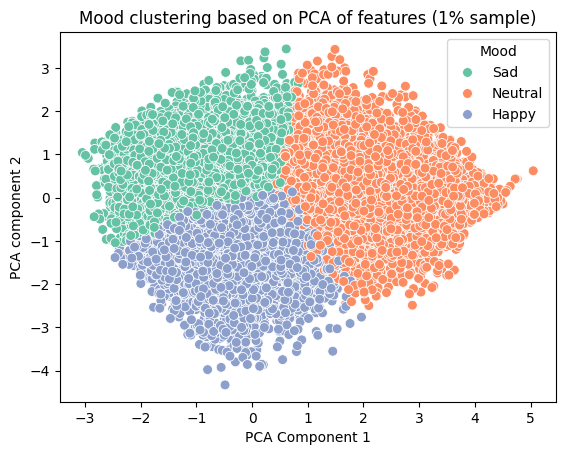

In [24]:
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import seaborn as sns

# Predict mood clusters
predictions_mood = kmeans_model.transform(features_df)

# Map mood labels
mood_labels = {0: "Sad", 1: "Happy", 2: "Neutral"}
predictions_mood = predictions_mood.withColumn(
    "mood",
    when(col("mood_score") == 0, "Sad")
    .when(col("mood_score") == 1, "Happy")
    .when(col("mood_score") == 2, "Neutral")
)

# Apply PCA to reduce dimensions to 2 components
pca = PCA(k = 2, inputCol = "features", outputCol = "pca_features")
pca_model = pca.fit(predictions_mood)
predictions_pca = pca_model.transform(predictions_mood)

# Extract PCA components for plotting
def extract_pca_components(pca_col):
    if pca_col and len(pca_col) == 2:
        return [float(pca_col[0]), float(pca_col[1])]
    return [float(0), float(0)]  # Default values in case of issues

extract_pca = udf(extract_pca_components, ArrayType(FloatType()))
predictions_pca = predictions_pca.withColumn("pca_components", extract_pca(col("pca_features")))

# Split PCA components into separate columns
predictions_pca = predictions_pca.withColumn("PCA1", col("pca_components")[0])
predictions_pca = predictions_pca.withColumn("PCA2", col("pca_components")[1])

# Take a radom 1% sample of the data 
sample_df = predictions_pca.sample(withReplacement = False, fraction = 0.01, seed = 42)

# Convert the sampled DataFrame to pandas for plotting 
sample_converted_df = sample_df.select("PCA1", "PCA2", "mood").toPandas()

# Scatter plot for PCA components with mood labels
sns.scatterplot(data = sample_converted_df, x = "PCA1", y= "PCA2", hue = "mood", palette= "Set2", s= 50)
plt.title("Mood clustering based on PCA of features (1% sample)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA component 2")
plt.legend(title = "Mood")
plt.show()

In [25]:
predictions_pca.cache()

DataFrame[artist_id: string, artist_name: string, album_name: string, genres: string, link_image: string, url: string, album_type: string, release_date_precision: string, track_id: string, name: string, preview: string, followers: double, popularity: double, danceability: double, energy: double, key: double, loudness: double, speechiness: double, acousticness: double, instrumentalness: double, liveness: double, valence: double, tempo: double, time_signature: double, features: vector, mood_score: int, mood: string, pca_features: vector, pca_components: array<float>, PCA1: float, PCA2: float]

In [42]:
predictions_pca.filter(predictions_pca['artist_name'] == 'Mr.Siro').select('artist_name', 'name', 'mood_score', 'mood').show(truncate = False)

24/12/07 15:20:03 WARN MemoryStore: Not enough space to cache rdd_622_1 in memory! (computed 40.1 MiB so far)
24/12/07 15:20:03 WARN BlockManager: Persisting block rdd_622_1 to disk instead.
24/12/07 15:20:13 WARN MemoryStore: Not enough space to cache rdd_622_1 in memory! (computed 153.4 MiB so far)
24/12/07 15:20:31 WARN MemoryStore: Not enough space to cache rdd_622_3 in memory! (computed 40.2 MiB so far)
24/12/07 15:20:31 WARN BlockManager: Persisting block rdd_622_3 to disk instead.
24/12/07 15:20:41 WARN MemoryStore: Not enough space to cache rdd_622_3 in memory! (computed 153.1 MiB so far)


+-----------+-----------------------------------------------------------------+----------+----+
|artist_name|name                                                             |mood_score|mood|
+-----------+-----------------------------------------------------------------+----------+----+
|Mr.Siro    |Trái Tim Em Cũng Biết Đau - Piano Version                        |0         |Sad |
|Mr.Siro    |Em - Piano Version                                               |0         |Sad |
|Mr.Siro    |Sống Xa Anh Chẳng Dễ Dàng - Piano Version                        |0         |Sad |
|Mr.Siro    |Em Đã Sai Vì Em Tin - Piano Version                              |0         |Sad |
|Mr.Siro    |Cánh Đồng Yêu Thương - Piano Version                             |0         |Sad |
|Mr.Siro    |Nguyện Làm Tri Kỷ - Piano Version                                |0         |Sad |
|Mr.Siro    |Mashup 5 Hit Songs In 2017                                       |0         |Sad |
|Mr.Siro    |Người Từng Yêu Anh Rất Sâu 

- Inverse the popularity and followers for sorted by popularity and followers below

In [26]:
final_df_mood_genre = predictions_pca

# Return followers and popularity to original values
followers_mean = tracks_cleaned_mood.select(mean(col("followers"))).first()[0]
followers_std = tracks_cleaned_mood.select(stddev(col("followers"))).first()[0]

popularity_mean = tracks_cleaned_mood.select(mean(col("popularity"))).first()[0]
popularity_std = tracks_cleaned_mood.select(stddev(col("popularity"))).first()[0]

final_df_mood_genre = final_df_mood_genre.withColumn('followers',  (final_df_mood_genre['followers'] * followers_std) + followers_mean)
final_df_mood_genre = final_df_mood_genre.withColumn('popularity', (final_df_mood_genre['popularity'] * popularity_std) + popularity_mean)

final_df_mood_genre.show(5)

+--------------------+-----------+--------------------+----------------+--------------------+--------------------+----------+----------------------+--------------------+-------------------+--------------------+-----------+----------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+----------+-------+--------------------+--------------------+----------+----------+
|           artist_id|artist_name|          album_name|          genres|          link_image|                 url|album_type|release_date_precision|            track_id|               name|             preview|  followers|popularity|        danceability|              energy|                 key|           loudness|         speechiness|       acousticness|    instrumentalness|            liveness|             valence|              t

4. Build recommendation songs by mood and genre

In [36]:
from pyspark.sql.functions import lit

def recommend_songs_by_mood_genre(df, mood, genre, num_recommend = 5):
    # Filter dataFrame by mood and genre
    filtered_tracks = df.filter(
        (col("mood") == lit(mood)) & (F.lower(col("genres")).contains(genre.lower()))
    )
    
    if filtered_tracks.count() == 0:
        print(f"No tracks found with mood {mood} and genre {genre}. Here are some other suggestions:")
        # If no tracks match both mood and genre, recommend random songs from the same mood
        # But if no tracks match with mood, recommend random songs from the same genre
        mood_tracks = df.filter(col("mood") == lit(mood))
        genre_tracks = df.filter(F.lower(col("genres")).contains(genre.lower()))
        
        if mood_tracks.count() == 0:
            print(f"No tracks found with mood. Showing random suggestions by genre {genre}:")
            genre_recommendations = genre_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            genre_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").show(truncate = False)
        else:
            print(f"No tracks found with genre. Showing random suggesstions by mood {mood}:")
            mood_recommendations = mood_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
            mood_recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").show(truncate = False)
        return

    recommendations = filtered_tracks.orderBy(col("popularity").desc(), col("followers").desc()).limit(num_recommend)
    
    print(f"Recommendations songs with mood {mood} and genre {genre}:")
    recommendations.select("artist_name", "name", "genres", "mood", "popularity", "link_image", "url", "preview").distinct().show(truncate = False)

In [37]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Happy", "v-pop", 5)

24/12/07 17:00:01 INFO CodeGenerator: Code generated in 32.534784 ms
24/12/07 17:00:01 INFO DAGScheduler: Registering RDD 701 (count at NativeMethodAccessorImpl.java:0) as input to shuffle 79
24/12/07 17:00:01 INFO DAGScheduler: Got map stage job 161 (count at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 17:00:01 INFO DAGScheduler: Final stage: ShuffleMapStage 798 (count at NativeMethodAccessorImpl.java:0)
24/12/07 17:00:01 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 796, ShuffleMapStage 797)
24/12/07 17:00:01 INFO DAGScheduler: Missing parents: List()
24/12/07 17:00:01 INFO DAGScheduler: Submitting ShuffleMapStage 798 (MapPartitionsRDD[701] at count at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 17:00:01 INFO MemoryStore: Block broadcast_246 stored as values in memory (estimated size 106.1 KiB, free 195.6 MiB)
24/12/07 17:00:01 INFO MemoryStore: Block broadcast_246_piece0 stored as bytes in memory (estimated size 44

Recommendations songs with mood Happy and genre v-pop:


24/12/07 17:00:07 INFO HashAggregateExec: spark.sql.codegen.aggregate.map.twolevel.enabled is set to true, but current version of codegened fast hashmap does not support this aggregate.
24/12/07 17:00:07 INFO HashAggregateExec: spark.sql.codegen.aggregate.map.twolevel.enabled is set to true, but current version of codegened fast hashmap does not support this aggregate.
24/12/07 17:00:07 INFO CodeGenerator: Code generated in 25.73162 ms
24/12/07 17:00:07 INFO CodeGenerator: Code generated in 15.558874 ms
24/12/07 17:00:07 INFO CodeGenerator: Code generated in 25.914654 ms
24/12/07 17:00:07 INFO SparkContext: Starting job: showString at <unknown>:0
24/12/07 17:00:07 INFO DAGScheduler: Registering RDD 710 (showString at <unknown>:0) as input to shuffle 80
24/12/07 17:00:07 INFO DAGScheduler: Got job 163 (showString at <unknown>:0) with 1 output partitions
24/12/07 17:00:07 INFO DAGScheduler: Final stage: ResultStage 810 (showString at <unknown>:0)
24/12/07 17:00:07 INFO DAGScheduler: Pare

+-----------+----------------------------------------------+------+-----+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|artist_name|name                                          |genres|mood |popularity|link_image                                                      |url                                                   |preview|
+-----------+----------------------------------------------+------+-----+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|tlinh      |những đốm sáng                                |v-pop |Happy|67.0      |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87da1d85d0445|https://open.spotify.com/artist/3diftVOq7aEIebXKkC34oR|null   |
|tlinh      |ghệ iu dấu của em ơi (ft. 52Hz) - Gonpop remix|v-pop |Happy|67.0      |https://i.scdn.co/image/ab6761610000e5eb230e62752ca87da1d85d0445

24/12/07 17:00:15 INFO Executor: Finished task 3.0 in stage 809.0 (TID 513). 12095 bytes result sent to driver
24/12/07 17:00:15 INFO TaskSetManager: Finished task 3.0 in stage 809.0 (TID 513) in 1887 ms on c110709c2f0f (executor driver) (4/4)
24/12/07 17:00:15 INFO TaskSchedulerImpl: Removed TaskSet 809.0, whose tasks have all completed, from pool 
24/12/07 17:00:15 INFO DAGScheduler: ShuffleMapStage 809 (showString at <unknown>:0) finished in 7.338 s
24/12/07 17:00:15 INFO DAGScheduler: looking for newly runnable stages
24/12/07 17:00:15 INFO DAGScheduler: running: Set()
24/12/07 17:00:15 INFO DAGScheduler: waiting: Set(ResultStage 810)
24/12/07 17:00:15 INFO DAGScheduler: failed: Set()
24/12/07 17:00:15 INFO DAGScheduler: Submitting ResultStage 810 (MapPartitionsRDD[714] at showString at <unknown>:0), which has no missing parents
24/12/07 17:00:15 INFO MemoryStore: Block broadcast_249 stored as values in memory (estimated size 115.4 KiB, free 196.3 MiB)
24/12/07 17:00:15 INFO Memory

In [38]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Sad", "v-pop indie", 5)

24/12/07 17:00:36 INFO CodeGenerator: Code generated in 27.980812 ms
24/12/07 17:00:36 INFO DAGScheduler: Registering RDD 719 (count at NativeMethodAccessorImpl.java:0) as input to shuffle 81
24/12/07 17:00:36 INFO DAGScheduler: Got map stage job 164 (count at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 17:00:36 INFO DAGScheduler: Final stage: ShuffleMapStage 815 (count at NativeMethodAccessorImpl.java:0)
24/12/07 17:00:36 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 814, ShuffleMapStage 813)
24/12/07 17:00:36 INFO DAGScheduler: Missing parents: List()
24/12/07 17:00:36 INFO DAGScheduler: Submitting ShuffleMapStage 815 (MapPartitionsRDD[719] at count at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 17:00:36 INFO MemoryStore: Block broadcast_250 stored as values in memory (estimated size 106.1 KiB, free 196.1 MiB)
24/12/07 17:00:36 INFO MemoryStore: Block broadcast_250_piece0 stored as bytes in memory (estimated size 44

No tracks found with mood Sad and genre v-pop indie. Here are some other suggestions:


24/12/07 17:00:41 INFO CodeGenerator: Code generated in 31.4707 ms
24/12/07 17:00:41 INFO DAGScheduler: Registering RDD 727 (count at NativeMethodAccessorImpl.java:0) as input to shuffle 82
24/12/07 17:00:41 INFO DAGScheduler: Got map stage job 166 (count at NativeMethodAccessorImpl.java:0) with 4 output partitions
24/12/07 17:00:41 INFO DAGScheduler: Final stage: ShuffleMapStage 826 (count at NativeMethodAccessorImpl.java:0)
24/12/07 17:00:41 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 825, ShuffleMapStage 824)
24/12/07 17:00:41 INFO DAGScheduler: Missing parents: List()
24/12/07 17:00:41 INFO DAGScheduler: Submitting ShuffleMapStage 826 (MapPartitionsRDD[727] at count at NativeMethodAccessorImpl.java:0), which has no missing parents
24/12/07 17:00:41 INFO MemoryStore: Block broadcast_252 stored as values in memory (estimated size 105.6 KiB, free 196.3 MiB)
24/12/07 17:00:41 INFO MemoryStore: Block broadcast_252_piece0 stored as bytes in memory (estimated size 43.8

No tracks found with genre. Showing random suggesstions by mood Sad:


24/12/07 17:00:46 INFO CodeGenerator: Code generated in 32.870749 ms
24/12/07 17:00:46 INFO SparkContext: Starting job: showString at <unknown>:0
24/12/07 17:00:46 INFO DAGScheduler: Got job 168 (showString at <unknown>:0) with 4 output partitions
24/12/07 17:00:46 INFO DAGScheduler: Final stage: ResultStage 837 (showString at <unknown>:0)
24/12/07 17:00:46 INFO DAGScheduler: Parents of final stage: List(ShuffleMapStage 836, ShuffleMapStage 835)
24/12/07 17:00:46 INFO DAGScheduler: Missing parents: List()
24/12/07 17:00:46 INFO DAGScheduler: Submitting ResultStage 837 (MapPartitionsRDD[736] at showString at <unknown>:0), which has no missing parents
24/12/07 17:00:46 INFO MemoryStore: Block broadcast_254 stored as values in memory (estimated size 113.1 KiB, free 196.3 MiB)
24/12/07 17:00:46 INFO MemoryStore: Block broadcast_254_piece0 stored as bytes in memory (estimated size 45.1 KiB, free 196.3 MiB)
24/12/07 17:00:46 INFO BlockManagerInfo: Added broadcast_254_piece0 in memory on c110

+------------+-------------------+------+----+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|artist_name |name               |genres|mood|popularity|link_image                                                      |url                                                   |preview|
+------------+-------------------+------+----+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|Taylor Swift|cardigan           |pop   |Sad |100.0     |https://i.scdn.co/image/ab6761610000e5ebe672b5f553298dcdccb0e676|https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02|null   |
|Taylor Swift|Mine               |pop   |Sad |100.0     |https://i.scdn.co/image/ab6761610000e5ebe672b5f553298dcdccb0e676|https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02|null   |
|Taylor Swift|cardigan           |pop   |Sad |100.0     |https://i.scd

24/12/07 17:00:53 INFO Executor: Finished task 3.0 in stage 837.0 (TID 528). 12375 bytes result sent to driver
24/12/07 17:00:53 INFO TaskSetManager: Finished task 3.0 in stage 837.0 (TID 528) in 1478 ms on c110709c2f0f (executor driver) (4/4)
24/12/07 17:00:53 INFO TaskSchedulerImpl: Removed TaskSet 837.0, whose tasks have all completed, from pool 
24/12/07 17:00:53 INFO DAGScheduler: ResultStage 837 (showString at <unknown>:0) finished in 6.462 s
24/12/07 17:00:53 INFO DAGScheduler: Job 168 is finished. Cancelling potential speculative or zombie tasks for this job
24/12/07 17:00:53 INFO TaskSchedulerImpl: Killing all running tasks in stage 837: Stage finished
24/12/07 17:00:53 INFO DAGScheduler: Job 168 finished: showString at <unknown>:0, took 6.470487 s
24/12/07 17:00:53 INFO CodeGenerator: Code generated in 26.418683 ms            


24/12/07 17:01:45 INFO BlockManagerInfo: Removed broadcast_254_piece0 on c110709c2f0f:46049 in memory (size: 45.1 KiB, free: 434.4 MiB)


In [48]:
recommend_songs_by_mood_genre(final_df_mood_genre, "Neutral", "v-rap", 5)

24/12/07 15:22:32 WARN MemoryStore: Not enough space to cache rdd_622_1 in memory! (computed 153.4 MiB so far)
24/12/07 15:22:32 WARN MemoryStore: Not enough space to cache rdd_622_2 in memory! (computed 153.5 MiB so far)
24/12/07 15:22:32 WARN MemoryStore: Not enough space to cache rdd_622_3 in memory! (computed 153.1 MiB so far)


No tracks found with mood Neutral and genre v-rap. Here are some other suggestions:


24/12/07 15:22:33 WARN MemoryStore: Not enough space to cache rdd_622_1 in memory! (computed 153.4 MiB so far)
24/12/07 15:22:33 WARN MemoryStore: Not enough space to cache rdd_622_2 in memory! (computed 153.5 MiB so far)
24/12/07 15:22:34 WARN MemoryStore: Not enough space to cache rdd_622_3 in memory! (computed 153.1 MiB so far)


No tracks found with genre. Showing random suggesstions by mood Neutral:


24/12/07 15:22:34 WARN MemoryStore: Not enough space to cache rdd_622_1 in memory! (computed 153.4 MiB so far)
24/12/07 15:22:35 WARN MemoryStore: Not enough space to cache rdd_622_2 in memory! (computed 153.5 MiB so far)
24/12/07 15:22:35 WARN MemoryStore: Not enough space to cache rdd_622_3 in memory! (computed 153.1 MiB so far)


+------------+--------------------------------------+------+-------+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|artist_name |name                                  |genres|mood   |popularity|link_image                                                      |url                                                   |preview|
+------------+--------------------------------------+------+-------+----------+----------------------------------------------------------------+------------------------------------------------------+-------+
|Taylor Swift|this is me trying                     |pop   |Neutral|100.0     |https://i.scdn.co/image/ab6761610000e5ebe672b5f553298dcdccb0e676|https://open.spotify.com/artist/06HL4z0CvFAxyc27GXpf02|null   |
|Taylor Swift|Wonderland                            |pop   |Neutral|100.0     |https://i.scdn.co/image/ab6761610000e5ebe672b5f553298dcdccb0e676|https://open.spotify.com

In [ ]:
#upload into SnowFlake
snowflake_connection_options = {
    "sfURL": "https://sl70006.southeast-asia.azure.snowflakecomputing.com",
    "sfUser": "HUYNHTHUAN", 
    "sfPassword": "Thuan123456",
    "sfWarehouse": "COMPUTE_WH",
    "sfDatabase": "SPOTIFY_RCM_SCHEMA" 
}

final_df_mood_genre = final_df_mood_genre.select('artist_id', 'artist_name', 'album_name',
                                                 'genres', 'link_image','url', 'album_type',
                                                 'release_date_precision', 'track_id', 'name', 
                                                 'preview', 'followers', 'mood')
final_df_mood_genre.write.format("snowflake") \
        .options(**snowflake_connection_options) \
        .option("dbtable", "RCM_MOOD_GENRES_TABLE") \
        .mode('overwrite') \
        .save()


IllegalArgumentException: Don't know how to save StructField(features,org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7,true) of type features to Snowflake

In [ ]:
RE